# Segmenting Customers based on Credit Card usage

###### -Harshul Varma

***

## Table of Content

[1.0 Introduction](#1)<br>
[2.0 Dataset](#dataset)<br>
&nbsp;&nbsp;[2.1 Loading Libraries](#2.1)<br>
&nbsp;&nbsp;[2.2 Loading Data](#2.2)<br>
&nbsp;&nbsp;[2.3 Cleaning and Preparing Data](#2.3)<br>
[3.0 Correlation between features](#3.0)<br>
[4.0 K-Means Clustering](#4.0)<br>
[5.0 PCA visualisations of clusters](#5.0)<br>
***

## 1.0 Introduction <a id='1'></a>

The goal of this notebook is to segment customers based on their credit card usage so that banks can target the clusters with appropriate marketing strategies and promotions
***

## 2.0 Dataset <a id='2'></a>

This dataset consists of the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables such as purchase frequency, payments, tenure etc.

### 2.1 Loading Libraries <a id='2.1'></a>

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics


### 2.2 Loading Data <a id='2.2'></a>

In [9]:
df = pd.read_csv("D:/Downloads/ccdata/CC GENERAL.csv")

In [10]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### 2.3 Cleaning and Preparing Data <a id='2.3'></a>

Let's check if there are any null values which we can substitue later

In [11]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Since most valus payment values are 0 where minimum payments are null, we can substitute null minimum payments with payment values.
The null credit limit is substituted by mean credit limit value.

In [12]:
df.loc[(df['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=df['PAYMENTS']
df.loc[(df['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']=df['CREDIT_LIMIT'].mean()

Customer ID is dropped since it is not neeeded for clustering.

In [13]:
df = df.drop(['CUST_ID'],axis=1)

***

## 3.0 Correlation between features <a id='3.0'></a>

Let us look at the pearson correlation between the features.

In [16]:
corr = df.corr(method='pearson')
corr

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.000000,0.322412,0.181261,0.164350,0.126469,0.496692,-0.077944,0.073166,-0.063186,0.449218,0.385152,0.154338,0.531267,0.322802,0.391633,-0.318959,0.072692
BALANCE_FREQUENCY,0.322412,1.000000,0.133674,0.104323,0.124292,0.099388,0.229715,0.202415,0.176079,0.191873,0.141555,0.189626,0.095795,0.065008,0.123257,-0.095082,0.119776
PURCHASES,0.181261,0.133674,1.000000,0.916845,0.679896,-0.051474,0.393017,0.498430,0.315567,-0.120143,-0.067175,0.689561,0.356959,0.603264,0.096168,0.180379,0.086288
ONEOFF_PURCHASES,0.164350,0.104323,0.916845,1.000000,0.330622,-0.031326,0.264937,0.524891,0.127729,-0.082628,-0.046212,0.545523,0.319721,0.567292,0.051873,0.132763,0.064150
INSTALLMENTS_PURCHASES,0.126469,0.124292,0.679896,0.330622,1.000000,-0.064244,0.442418,0.214042,0.511351,-0.132318,-0.073999,0.628108,0.256496,0.384084,0.131947,0.182569,0.086143
CASH_ADVANCE,0.496692,0.099388,-0.051474,-0.031326,-0.064244,1.000000,-0.215507,-0.086754,-0.177070,0.628522,0.656498,-0.075850,0.303983,0.453238,0.137774,-0.152935,-0.068312
PURCHASES_FREQUENCY,-0.077944,0.229715,0.393017,0.264937,0.442418,-0.215507,1.000000,0.501343,0.862934,-0.308478,-0.203478,0.568430,0.119778,0.103464,0.004717,0.305802,0.061506
ONEOFF_PURCHASES_FREQUENCY,0.073166,0.202415,0.498430,0.524891,0.214042,-0.086754,0.501343,1.000000,0.142329,-0.111716,-0.069088,0.544869,0.295030,0.243537,-0.027564,0.157531,0.082466
PURCHASES_INSTALLMENTS_FREQUENCY,-0.063186,0.176079,0.315567,0.127729,0.511351,-0.177070,0.862934,0.142329,1.000000,-0.262958,-0.169207,0.529975,0.060752,0.085551,0.030540,0.250087,0.073275
CASH_ADVANCE_FREQUENCY,0.449218,0.191873,-0.120143,-0.082628,-0.132318,0.628522,-0.308478,-0.111716,-0.262958,1.000000,0.799561,-0.131168,0.132616,0.183192,0.097947,-0.249773,-0.133372


Since some features are highly correlated, we can remove them from our dataset to form clusters. A threshold of >0.6 pearson correlation is chosen as 'highly correlated'.

In [52]:
high_corr  = np.where(corr>0.6)
high_corr =[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr) if x!=y and x<y]

In [53]:
high_corr

[('PURCHASES', 'ONEOFF_PURCHASES'),
 ('PURCHASES', 'INSTALLMENTS_PURCHASES'),
 ('PURCHASES', 'PURCHASES_TRX'),
 ('PURCHASES', 'PAYMENTS'),
 ('INSTALLMENTS_PURCHASES', 'PURCHASES_TRX'),
 ('CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY'),
 ('CASH_ADVANCE', 'CASH_ADVANCE_TRX'),
 ('PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY'),
 ('CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX')]

In [54]:
columns = ['ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES','PURCHASES_TRX','PAYMENTS','CASH_ADVANCE_FREQUENCY',
           'CASH_ADVANCE_TRX','PURCHASES_INSTALLMENTS_FREQUENCY']

In [56]:
df = df.drop(columns,axis=1)

We are left with the following columns we will use to form the clusters.

In [58]:
print(df.columns)

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'CREDIT_LIMIT', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'], dtype='object')

***

## 4.0 K-Means Clustering <a id='4.0'></a>

Lets normalize the data before clustering

In [59]:
X = np.asarray(df)

In [60]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Selecting number of cluster using the elbow method.

In [82]:
n_clusters=30
cost=[]
for i in range(1,n_clusters):
    kmean= KMeans(i)
    kmean.fit(X)
    cost.append(kmean.inertia_)  

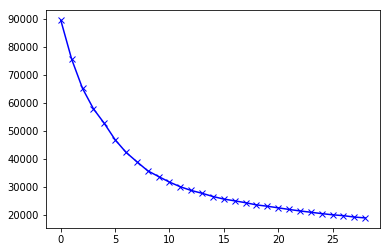

In [83]:
plt.plot(cost, 'bx-')

It seems 8 clusters seems good according to elbow method but since it is not very clear, I will also use silhouette analysis to decide number of clusters.

maximum is 0.2700842880364047, which occurs at k=2


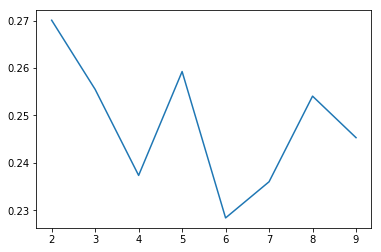

In [77]:
START = 2
END = 10
scores = []
for k in range(START, END):

    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    
    scores.append(metrics.silhouette_score(X, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

Since two clusters are too less for our final goal, I will choose 5 clusters based on next maximum silhouette score

In [78]:
kmean= KMeans(5)
kmean.fit(X)
labels=kmean.labels_

Creating dataframes with cluster column so that we can analyse each cluster.

In [79]:
clusters=pd.concat([df, pd.DataFrame({'CLUSTER':labels})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,CREDIT_LIMIT,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CLUSTER
0,40.900749,0.818182,95.40,0.000000,0.166667,0.000000,1000.0,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,6442.945483,0.000000,0.000000,7000.0,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,0.000000,1.000000,1.000000,7500.0,627.284787,0.000000,12,1
3,1666.670542,0.636364,1499.00,205.788017,0.083333,0.083333,7500.0,0.000000,0.000000,12,0
4,817.714335,1.000000,16.00,0.000000,0.083333,0.083333,1200.0,244.791237,0.000000,12,0


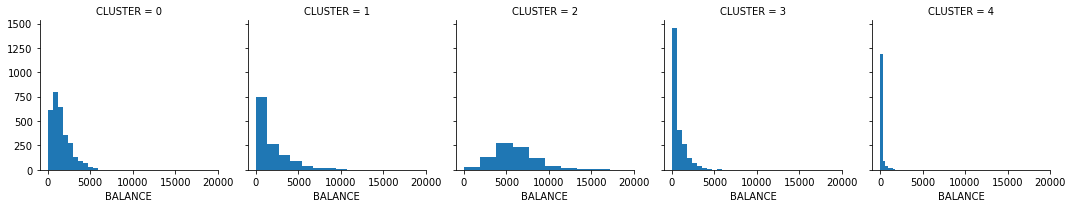

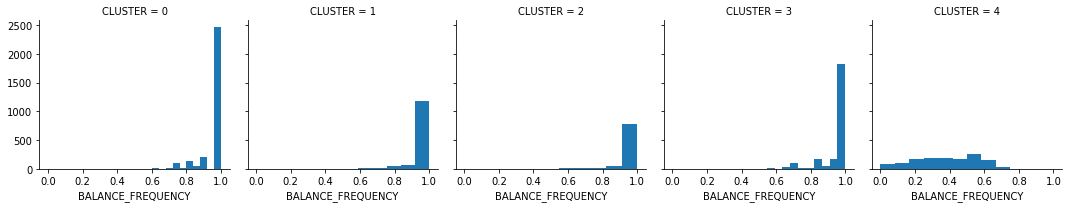

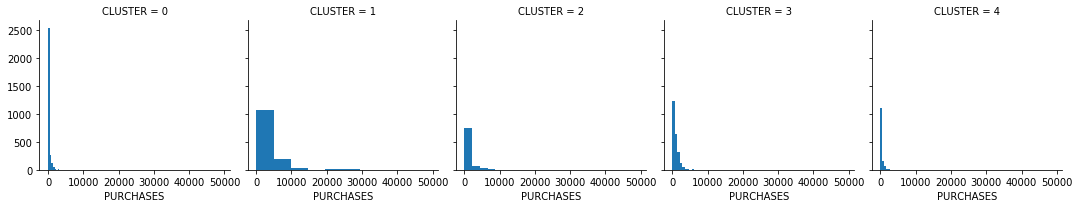

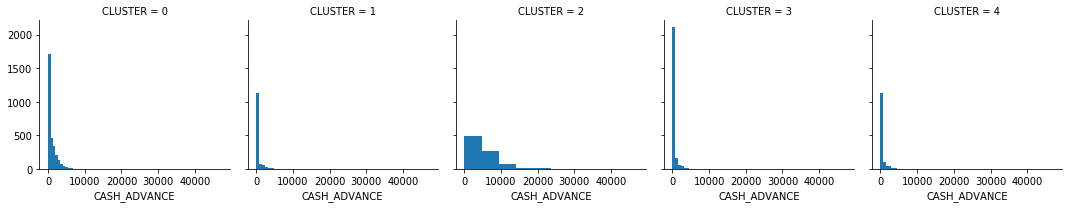

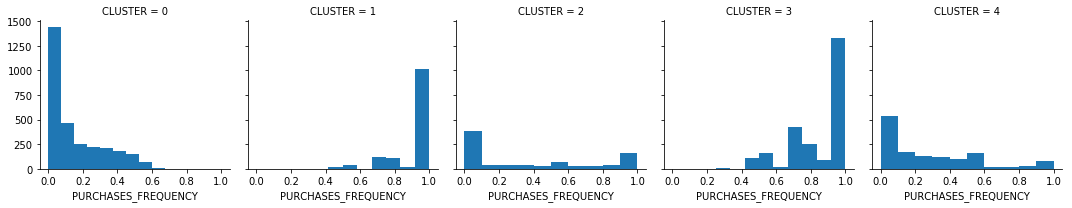

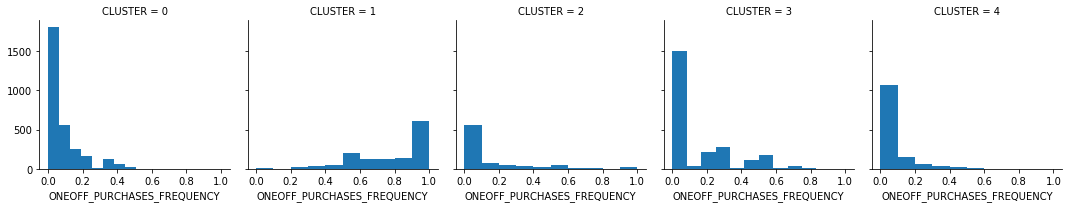

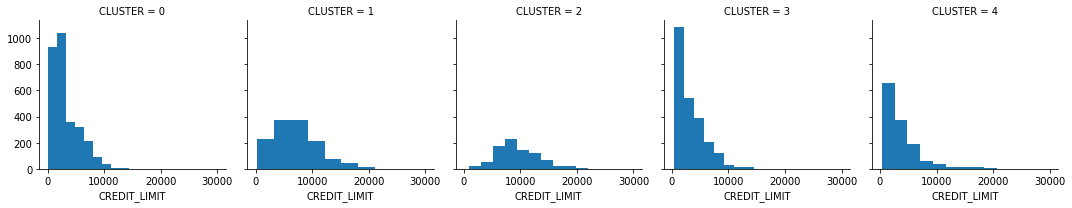

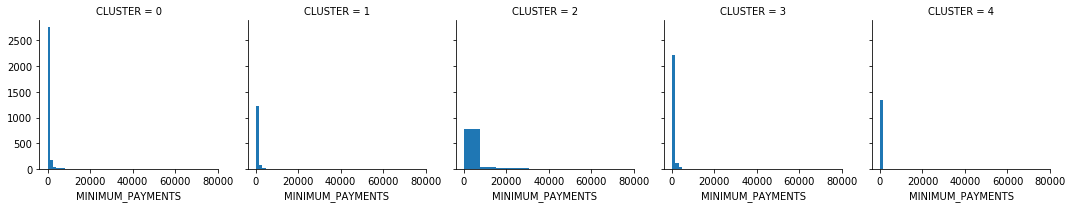

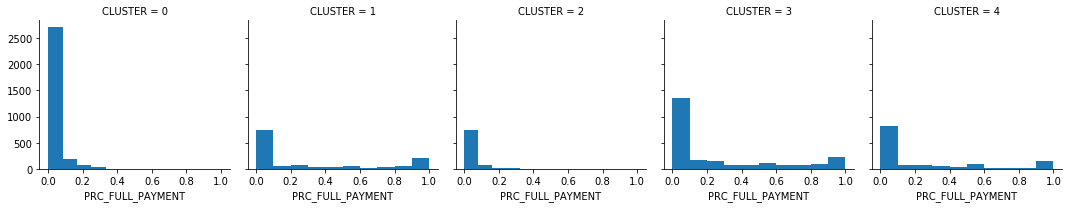

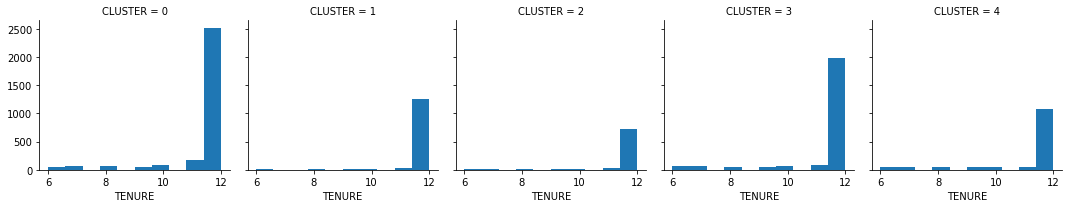

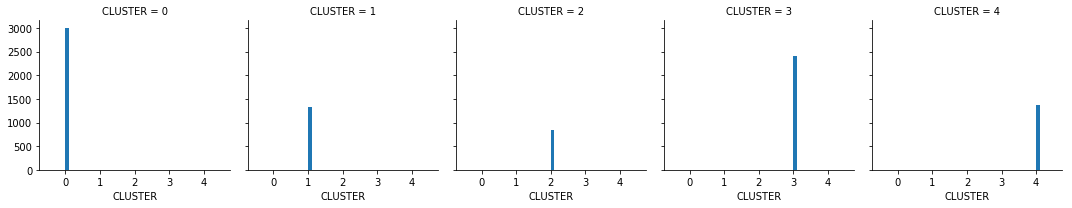

In [81]:
pd.set_option('display.width', 10000)
for c in clusters:
    grid= sns.FacetGrid(clusters, col='CLUSTER')
    grid.map(plt.hist, c)

Using visualisation we can see the clusters represent the following information: <br>
**Cluster 0**: High Balance frequency and tenure but lowest in everything else, this cluster also has highest number of people <br>
**Cluster 1**: Higher purchase and one-off purchase frequency but relatively lower balance<br>
**Cluster 2**: Higher balance and lower purchases and thus lower payments<br>
**Cluster 3**: Lowest Balance but highest purchase frequency despite low one off purchases. Also more likely for full payments<br>
**Cluster 4**: Low in everything but medium sized cluster suggesting low activity with the credit card<br>

***

## 5.0 PCA visualisation of clusters <a id='5.0'></a>

We can use PCA to transform the data in 2-Dimensional data

In [105]:
pca = PCA(2).fit(X)
pca_2d = pca.transform(X)

Finally we can visualise the clusters using the PCA transformed data

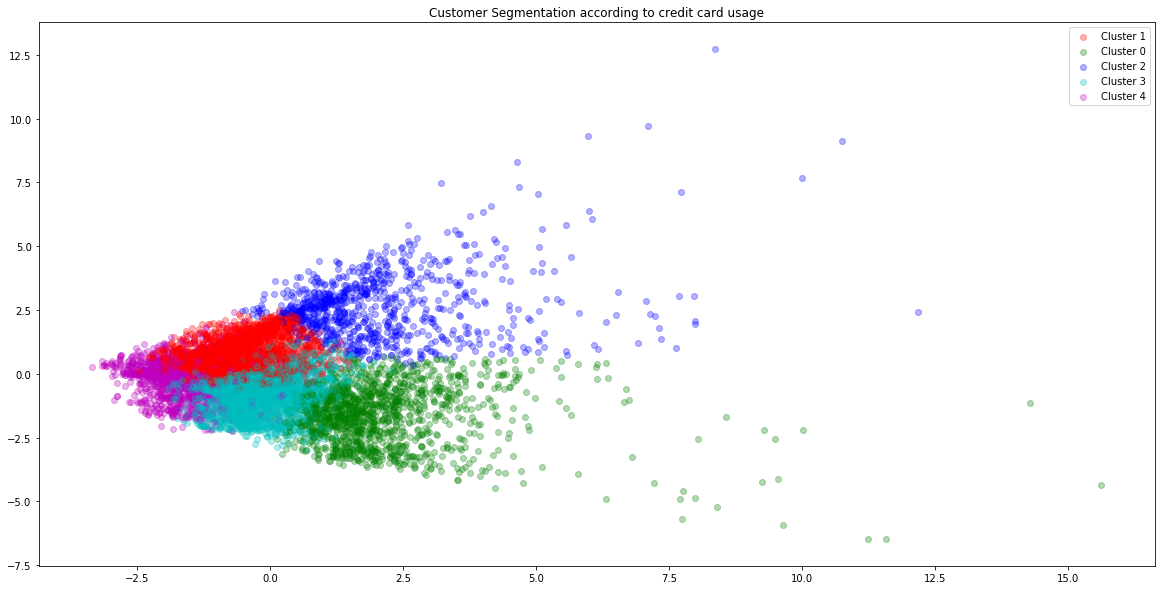

In [111]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(0, pca_2d.shape[0]):
    if labels[i] == 0:
        c1 = plt.scatter(pca_2d[i,0], pca_2d[i, 1], c='r',alpha=0.3)
    elif labels[i] == 1:
        c2 = plt.scatter(pca_2d[i,0], pca_2d[i, 1], c='g',alpha=0.3)
    elif labels[i] == 2:
        c3 = plt.scatter(pca_2d[i,0], pca_2d[i, 1], c='b',alpha=0.3)
    elif labels[i] == 3:
        c4 = plt.scatter(pca_2d[i,0], pca_2d[i, 1], c='c',alpha=0.3)
    elif labels[i] == 4:
        c5 = plt.scatter(pca_2d[i,0], pca_2d[i, 1], c='m',alpha=0.3)

plt.legend([c1, c2, c3,c4,c5], ['Cluster 1', 'Cluster 0', 'Cluster 2','Cluster 3','Cluster 4'])
plt.title('Customer Segmentation according to credit card usage')
plt.show()

***